In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Goal 2.1: 

### Cluster years based on construction indicators (e.g., Payment Public Civil Engineering, Award Private Building) and analyze their relationship with steel demand. Propose strategies for aligning supply with projected infrastructure projects.

## Reading the file

- The following code converts the file from excel to pandars dataframe.
- We have included all the demand factors alone.

In [23]:
file_path = r'Demand2.xlsx'
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)
df = pd.read_excel(file_path, sheet_name='Sheet1')
df.head()

['Sheet1', 'Economic Driver']


,Year,Award Public Building,Award Public Civil Engineering,Award Private Building,Award Private Civil Engineering,Payment Public Building,Payment Public Civil Engineering,Payment Private Building,Payment Private Civil Engineering,is_expansion,is_crisis,is_slowdown,is_stabilization,is_recovery,GDP
0,1980-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,46309.5
1,1981-12-31,2902.0,927.0,2809.0,0.0,1530.0,951.0,1692.0,0.0,1,0,0,0,0,51318.3
2,1982-12-31,3898.0,785.0,4539.0,0.0,2655.0,976.0,2527.0,0.0,1,0,0,0,0,54963.0
3,1983-12-31,3833.0,1626.0,4151.0,0.0,3920.0,1006.0,3267.0,0.0,1,0,0,0,0,59664.8
4,1984-12-31,3189.0,2280.0,1494.0,0.0,3943.0,1193.0,3366.0,0.0,1,0,0,0,0,64910.7


## Normalising

- This step is to normalise and then fill the missing value with 0
- It does z-score normalization

In [24]:
features = df.drop(columns=['Year']).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## Elbow method to calculate the appropriate number of clusters

**Steps:**
- For the number of clusters, we test from 1 to 10
- For each number, we build a Kmeans model with that amount of clusters
- We calculate the sum of the inertias of the points around their assigned cluster centroid and store it
- We then plot a graph of the inertia against the cluster number
- For each attempt, we set the `random_state` to 42 for reproduceability

**Interpretation:**
- What we are looking out for is the point beyond which there is decreasing returns  
  in the reduction of inertia for increasing cluster number
- Inertia represents the tightness of the groupings
- Inertia will always decrease the more groupings there are as the points will be closer to the centroid
- Therefore, we look at the point at which we no longer see substantial decreases in inertia
- By doing so, we arrive at the number of clusters that are able to explain the data well but do not overfit it.
- From our graph below, it is easy to see that it k=3 is the elbow

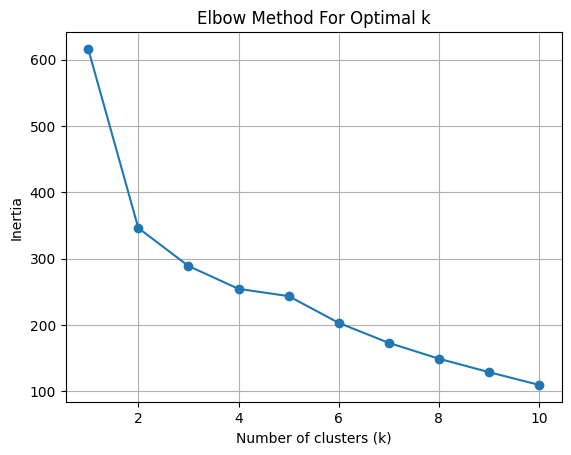

In [25]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

## Making the model

- We now use the sklearn library to create the model
- We pass in the random state from earlier to reproduce the results

In [26]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

df.head()

,Year,Award Public Building,Award Public Civil Engineering,Award Private Building,Award Private Civil Engineering,Payment Public Building,Payment Public Civil Engineering,Payment Private Building,Payment Private Civil Engineering,is_expansion,is_crisis,is_slowdown,is_stabilization,is_recovery,GDP,Cluster
0,1980-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,46309.5,2
1,1981-12-31,2902.0,927.0,2809.0,0.0,1530.0,951.0,1692.0,0.0,1,0,0,0,0,51318.3,2
2,1982-12-31,3898.0,785.0,4539.0,0.0,2655.0,976.0,2527.0,0.0,1,0,0,0,0,54963.0,2
3,1983-12-31,3833.0,1626.0,4151.0,0.0,3920.0,1006.0,3267.0,0.0,1,0,0,0,0,59664.8,2
4,1984-12-31,3189.0,2280.0,1494.0,0.0,3943.0,1193.0,3366.0,0.0,1,0,0,0,0,64910.7,2


## Getting the separate clusters

- This part is about generating the different clusters in dataframe format for easier viewing and also computing the frequency for each type of year.

In [27]:
df_driver = pd.read_excel(file_path, sheet_name="Economic Driver")
df_driver.head()

,Year,Economic Driver
0,1980-12-31,"Early industrialization, small-scale local pro..."
1,1981-12-31,Light manufacturing expansion
2,1982-12-31,Growth in shipbuilding & heavy industry
3,1983-12-31,HDB & public housing expansion
4,1984-12-31,Increased infrastructure spending


In [28]:
years_by_cluster = df.sort_values(by=['Cluster', 'Year'])
avgs = {}
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster_id].sort_values('Year').reset_index(drop=True)
    cluster_stats = cluster_df.describe()
    avgs[cluster_id] = cluster_stats

In [29]:
for x in avgs:
    avgs[x].to_csv(f"avg for cluster {x}.csv")

In [34]:
years_by_cluster = df[['Year','Cluster', 'is_expansion', 'is_stabilization', 'is_recovery','is_crisis', 'is_slowdown']].sort_values(by= ['Cluster', 'Year'])

columns = ['Cluster', 'Year', 'is_expansion', 'is_crisis', 'is_slowdown', 'is_stabilization', 'is_recovery']

cluster_dfs = {}

for cluster_id in sorted(df['Cluster'].unique()):
    cluster_df = df[df['Cluster'] == cluster_id][columns].sort_values('Year').reset_index(drop=True)
    df_driver_filtered = df_driver[df_driver['Year'].isin(cluster_df['Year'])].sort_values(by= ['Year'])
    df_to_add = df_driver_filtered.drop('Year', axis=1).set_index(cluster_df.index)

    df2 = pd.concat([cluster_df, df_to_add], axis=1)
    
    column_sums = cluster_df[['is_expansion', 'is_crisis', 'is_slowdown', 'is_stabilization', 'is_recovery']].sum()
    
    frequency_row = {
        'Cluster': 'Frequency',
        'Year': cluster_df['Year'].count(), 
        **column_sums.to_dict()
    }
    
    final_cluster_df = pd.concat([df2, pd.DataFrame([frequency_row])], ignore_index=True)
    cluster_dfs[cluster_id] = final_cluster_df


## Cluster 0: Crisis years

**General trends**

- None of the years in this group are expansions years, with most belonging to crisis years.  
  This indicates this is a grouping consisting of low steel demand years and this is backed up by the original economic drivers
  provided to us as well  

- These years represent economic hardship:
    - 1985: Singapore's first recession post independance
    - 1996-1999: Pre and Post Asian Financial Crisis
    - 2000 - 2003: Post-Dotcom Bubble and SARS Outbreak
    - 2005: Fluctuating global steel prices

In [31]:
cluster_dfs[0]

,Cluster,Year,is_expansion,is_crisis,is_slowdown,is_stabilization,is_recovery,Economic Driver
0,0,1985-12-31 00:00:00,0,1,0,0,0,1985 Recession slows demand
1,0,1996-12-31 00:00:00,0,0,1,0,0,"Rapid urbanization, but overheating signs"
2,0,1997-12-31 00:00:00,0,1,0,0,0,"Asian Financial Crisis begins, demand slows"
3,0,1998-12-31 00:00:00,0,1,0,0,0,"Recession deepens, infrastructure cuts"
4,0,1999-12-31 00:00:00,0,0,0,1,0,Gradual economic stabilization
5,0,2000-12-31 00:00:00,0,0,0,0,1,"Recovery, government stimulus"
6,0,2001-12-31 00:00:00,0,0,1,0,0,Post-dot-com bubble adjustment
7,0,2002-12-31 00:00:00,0,0,0,0,1,Recovery in construction sector
8,0,2003-12-31 00:00:00,0,1,0,0,0,SARS outbreak impacts
9,0,2005-12-31 00:00:00,0,1,0,0,0,Global steel price volatility


## Cluster 1: Regime Shift/Moderate Years
**General Trends:**

- This cluster represents a mix of moderate economic activity with intermittent expansion periods, but no consistent growth across all years. These years show economic recovery followed by slowdowns or stabilization periods. The expansion years are few, and they tend to be preceded or followed by recovery, stabilization, or slowdown years.  

- These years represent a combination of growth and recovery, mixed with slower economic phases:
    - 2008: Global Financial Crisis Hits Q4
    - 2009-2013: Recovery, government stimulus, and stabilization
    - 2014-2015: Continued post-crisis recovery with challenges like oil price crashes
    - 2016-2019: Growth and construction activities followed by external challenges
    - 2020-2023: Ongoing recovery and economic pressures

- This results in a more volatile steel demand, where in some years due to the growth, it is very high, whereas in other years, it is moderate or low due to the state of the macroeconomy

- The fact that all years post 2008 are included in one big group is an indicator of a regime shift since 2008. we discuss it in greater detail below.

**Spike in 2008**

- The awards and payments since 2008 have underwent a massive spike. For example, the average `Award Public Contract` pre-2008 was 3851.80 mil  

- However, post 2008, the average of the same has been 8719.20 mil  

- There is a similar bump across all awards and payments since 2008  

- Furthermore, the values stayed high after 2008

- We believe this could be due to a variety of factors. We have highlighted 2 that we think apply to Singapore and hence, NatSteel significantly:
    - Firstly, 2008 is the year the LTA committed to improve the public transport network in Singapore in its master plan
    - It announced it would increase the rail network from 100km to 278km in 2020, pledging 100km of rail network constructions for the nect 10 years
    - Secondly, the URA master Plan for 2008 announced several significant strategies, such as the shift to Marina Bay as the financial centre of
      Singapore, the building of Jurong Gateway, and the enhancement of Orchard Road
    - Secondly, international policy of the US was favourable during this time, with the new Barack Obama's adminstration even launching the "Pivot to Asia" scheme a few years later in 2012.
    - Although NatSteel mainly exports steel to the Asian region, other countries in the region supply to the US resulting in a policy such as this favoring Singapore, and hence, NatSteel.  
- We believe that these factors along with 2006-2008 being Singapore's golden period for construction resulted in the sudden spike
- Furthermore, apart from this initial spike, we think that the long term nature of these projects, projected for the next 20 years (and 10+ years in terms of the international policy) resulted in the values staying that high.

**Regime Shift**

- It is also clear that the years post 2008, as a result of the values being at a different scale from the previous years, reflect a regime shift

- However, not only does the values indicate a regime shift, but post 2008 marks a shift in the nature of the mechanisms of trade across the world.

- Unlike previous years, which either neatly fell into high activity or low activity, here we have years that are expanding preceded by recessions/slowdowns or recoveries, while crisis are evenly spread as well.

- It highlights a more volatile state of the world, and therefore, although there are increases in production and decreases, they cannot be separated and placed in other groups as they are interrelated and mark a regime shift

- Hence, it can also be said that broadly, the steel demand across these years is moderate. While there are years with high steel demand, such as in the early years of this cluster, it has been far more volatile since, and hence on average there is cautious steel demand as opposed to strong and incresing steel demand as shown in the next cluster.

- However, it is a limitation of this model that it is unable to further categorise the years within these regimes.
    - A possible improvement could be that, if we were to acquire quarterly data, we would have enough data to conduct a separate Kmeans analysis on this regime alone, and thereby cluster the years better

In [32]:
cluster_dfs[1]

,Cluster,Year,is_expansion,is_crisis,is_slowdown,is_stabilization,is_recovery,Economic Driver
0,1,2008-12-31 00:00:00,0,1,0,0,0,Global Financial Crisis hits Q4
1,1,2009-12-31 00:00:00,0,0,0,0,1,Stimulus packages implemented
2,1,2010-12-31 00:00:00,0,0,0,0,1,Post-crisis recovery phase
3,1,2011-12-31 00:00:00,1,0,0,0,0,Record construction activity
4,1,2012-12-31 00:00:00,0,0,1,0,0,Cooling measures in property market
5,1,2013-12-31 00:00:00,0,0,1,0,0,Local production declines sharply
6,1,2014-12-31 00:00:00,0,1,0,0,0,Oil price crash affects marine sector
7,1,2015-12-31 00:00:00,1,0,0,0,0,SG50 infrastructure projects
8,1,2016-12-31 00:00:00,0,1,0,0,0,Global steel oversupply crisis
9,1,2017-12-31 00:00:00,0,0,1,0,0,Construction slowdown


## Cluster 2: Expansion Years

**General Trends**

- This cluster represents years with strong construction activity, and hence high steel demand. All of the years barring 1986 are expansion years.  
- The years can be broadly categorised as follows:
    - 1980-1984: Restructuring of the economy
    - 1986-1996: Sustained Economic Growth
    - 2004, 2006-2007/2008: Growth periods inbetween crises

- Limitations of model:
    - We believe 1986 is an anamoly and should be classfied with 1985. This is because it is a recovery year that followed a preceding year.  

    - One reason might be that for `Award Private Civil Engineering`, 1986 had 4 mil while 1984 had 0 mil, similarly with `Payment Private Civil Engineering` while ` Payment public Civil Engineering` was substantial higher than in 1984 as well.  

    - We believe for these reasons the model might have classified 1986 under expansion as opposed to under crisis.  

    - While 1985 having 0 mil might be a dataset limitation, a possible improvement to our model is to incorporate weights to account for what is the biggest drivers of steel demand.  

        - Under such a model, `Award Public Civil Engineering` would have one of the higher weights as it represents large scale public civil engineering projects such as MRT lines/roads/bridges etc that drive steel demand.  

        - For 1984, `Award Public Civil Engineering` was much higher than in 1986

In [33]:
cluster_dfs[2]

,Cluster,Year,is_expansion,is_crisis,is_slowdown,is_stabilization,is_recovery,Economic Driver
0,2,1980-12-31 00:00:00,1,0,0,0,0,"Early industrialization, small-scale local pro..."
1,2,1981-12-31 00:00:00,1,0,0,0,0,Light manufacturing expansion
2,2,1982-12-31 00:00:00,1,0,0,0,0,Growth in shipbuilding & heavy industry
3,2,1983-12-31 00:00:00,1,0,0,0,0,HDB & public housing expansion
4,2,1984-12-31 00:00:00,1,0,0,0,0,Increased infrastructure spending
5,2,1986-12-31 00:00:00,0,0,0,0,1,"Economic recovery, MRT construction starts"
6,2,1987-12-31 00:00:00,1,0,0,0,0,"Shipbuilding, industrial expansion"
7,2,1988-12-31 00:00:00,1,0,0,0,0,"Strong GDP growth, high infrastructure demand"
8,2,1989-12-31 00:00:00,1,0,0,0,0,Singapore port expansion
9,2,1990-12-31 00:00:00,1,0,0,0,0,"Peak construction boom, commercial skyscrapers"


## Main Insight: 2008 onwards reflects a VUCA world and a regime shift that necessitates a different outlook in recommending strategies